# Moving averages crossover strategy#

In this excersize we will simulate a moving-averages crossover strategy. The steps taken are typical workflow for a strategy development:

1. Get the data and divide the dataset in training and testing parts
2. Build a strategy using training part, optimize if desired
3. Test performance on the testing, out-of-sample data



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tradingWithPython as twp # main toolkit functions
import tradingWithPython.lib.yahooFinance as yf # yahoo finance module
import pandas as pd # as usual.

twp.extra.setNotebookStyle()

First, get the data from yahoo finance. We only need the closing prices, adjusted for splits and dividends. This price is provided by yahoo as `adj_close`

Got 4325 days of data


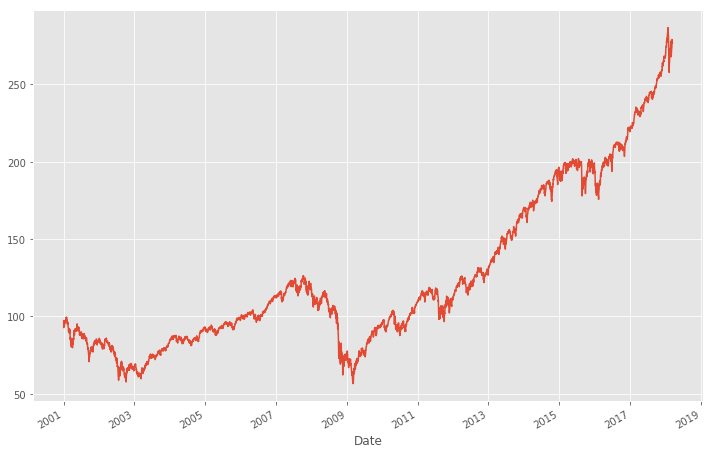

In [3]:
symbol = 'SPY'
price = yf.getHistoricData(symbol,sDate = (2001,1,1))['adj_close'] # get adj_close data

price.plot()

## Divide dataset##
To test strategy performance out-of-sample we will first divide the dataset in two parts:

* train : data to develop and optimize strategy on
* test : out-of-sample data, only for testing

In [4]:
train = price[:-500] # all data except last 500 days


## Develop strategy##
Here we will use a simple moving-average crossover

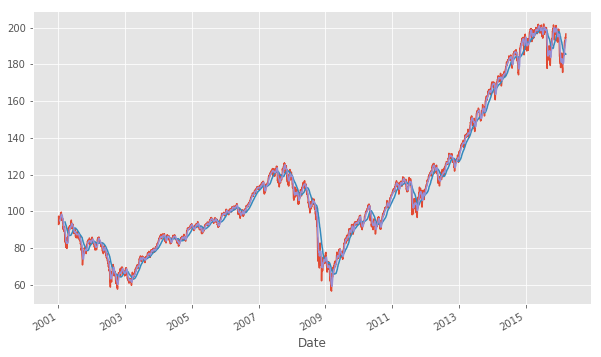

In [5]:
maSlow = train.rolling(window=50).mean() # slow moving average
maFast = train.rolling(10).mean() # fast moving average

#----plot all data
figsize(10,6)
train.plot()
maSlow.plot()
maFast.plot()

We will go long when *maFast* is above *maSlow* and short otherwise. Each time we will hold 10 shares of SPY

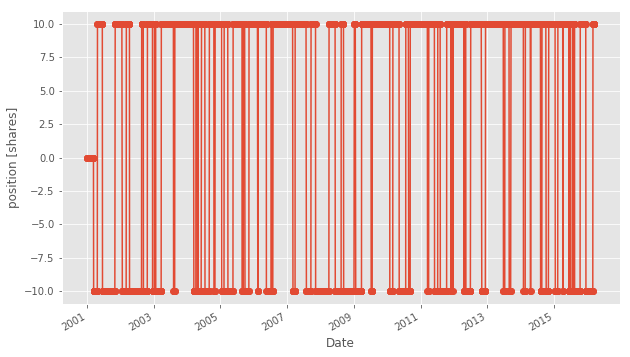

In [6]:
pos = pd.Series(index = train.index, data=0) # init position series, default value is 0

pos[maFast>maSlow] = 10 # shares long when maFast>maSlow
pos[maFast<=maSlow] = -10 # shares short when maFast<maSlow

pos.plot(style='o-')
ylabel('position [shares]')

To compute pnl, I just use the `pos2pnl` function from `tradingWithPython` module. Take a look at the code [here](https://code.google.com/p/trading-with-python/source/browse/trunk/lib/functions.py#71). It takes price and position in shares and returns a data frame containing *cash,stock,transaction cost* and *total pnl* values.

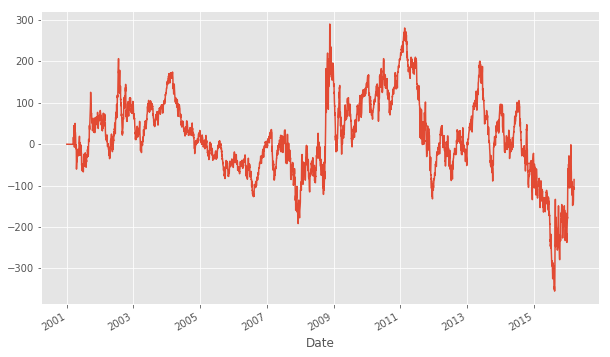

In [7]:
pnl = twp.pos2pnl(train,pos) # pos2pnl , returns *cumulative* pnl, along with cash and transaction costs
pnl['total'].plot()

Now we can rewrite the code above in a function form:

In [8]:
def maCrossoverStrategy(price,fastPeriod=10, slowPeriod=20, shares = 10):
    """ simulate moving average crossover strategy """
    maSlow = price.rolling(slowPeriod).mean() # slow moving average
    maFast = price.rolling(fastPeriod).mean() # fast moving average
    
    pos = pd.Series(index = price.index, data=0) # init position series

    pos[maFast>maSlow] = shares # long position
    pos[maFast<=maSlow] = -shares # short position
    
    return twp.pos2pnl(price,pos)['total']



test the function to ensure the result is identical to what we calculated above

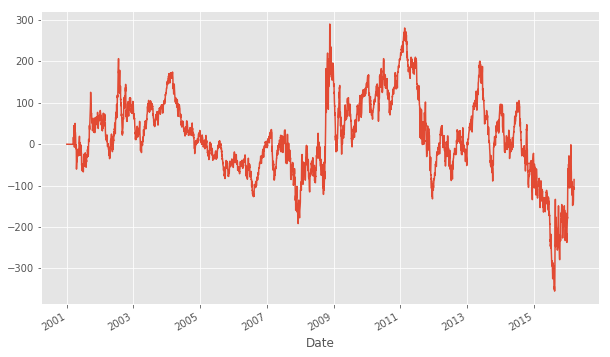

In [9]:
pnl = maCrossoverStrategy(train,10,50)
pnl.plot()

ok, this looks good. now we can continue optimizing this strategy:

## Make a parameter scan


[ref]: # (backtesting - parameter scan)

In [10]:
fastPeriod = arange(1,20,1) # fast goes from 1 to 20 in steps of 1
slowPeriod = arange(20,200,5) # slow goes from 20 to 200 in steps of 5

SH = np.zeros((len(fastPeriod),len(slowPeriod)))

from tradingWithPython.lib.extra import ProgressBar
pBar = ProgressBar(len(fastPeriod)-1)

for i, f in enumerate(fastPeriod):
    pBar.animate(i)
    for j, s in enumerate(slowPeriod):
        pnl = maCrossoverStrategy(train, fastPeriod=f, slowPeriod=s) # this is a cumulative pnl
        SH[i,j] = twp.sharpe(pnl.diff()) # !!! sharpe() only works with daily pnl, NOT cumulative one. To convert back to daily, use .diff()
        



 [*********************100%***********************]  18 of 18 complete

plot results in a heatmap plot

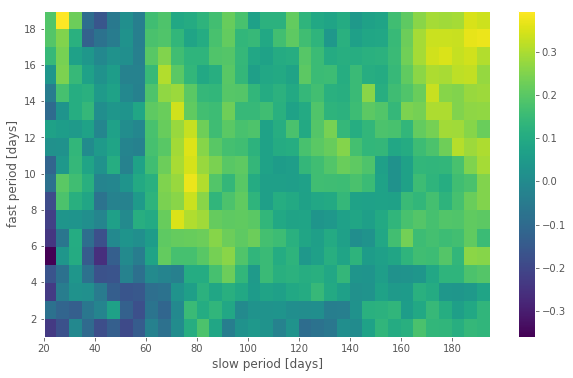

In [11]:
pcolor(slowPeriod,fastPeriod, SH)
ylabel('fast period [days]')
xlabel('slow period [days]');
colorbar();

a 'hot-spot' is somewhere in the right upper corner. We can now find the maximum values. Finding a good way to do this (I am accustomed to Matlab) took me quite some time, but [`unravel_index`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.unravel_index.html) turned out to be the best solution.

In [12]:
i,j = np.unravel_index(SH.argmax(), SH.shape) # find index of optimum values. .
                                              # see numpy docs of `unravel_index` 
print('Maximum sharpe: %.2f' % SH[i,j])
print('Optimum fastPeriod %i' % fastPeriod[i])
print('Optimum slowPeriod %i' % slowPeriod[j])

Maximum sharpe: 0.39
Optimum fastPeriod 18
Optimum slowPeriod 25


The 'hot spot' is exactly where we would expect it to be looking at the heatmap. Now let's recalculate the strategy with optimal parameters

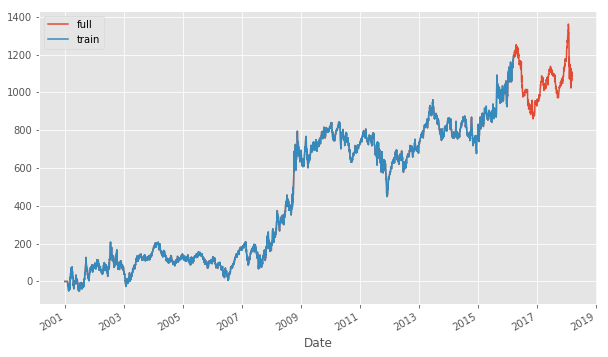

In [13]:
df = pd.DataFrame(index = price.index)
df['full'] = maCrossoverStrategy(price,fastPeriod[i],slowPeriod[j])
df['train'] = maCrossoverStrategy(train,fastPeriod[i],slowPeriod[j])
df.plot()


## Conclusion
Well, even after optimization the results of moving averages crossover are disappointing. Needless to say, out-of-sample performance is not better.
